In [1]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Receive input

real_data_path = input("Enter path for real data: ")
real_latent_path = input("Enter path for real latent: ")
start_age = int(input("Enter start age (days): "))
end_age = int(input("Enter end age (days): "))
num_of_vid = input("Enter video number: ")

experiment = "video" + num_of_vid + "_plot_" + str(start_age) + "_to_" + str(end_age)

if not os.path.exists("Results/" + experiment):
    os.mkdir("Results/" + experiment)

Enter path for real data: real_data
Enter path for real latent: real_latent
Enter start age (days): 6940
Enter end age (days): 8790
Enter video number: 1


In [3]:
def findInterpolator(start, end):

    def interpolator(coefficient):
        return ((end - start) * coefficient) + start

    return interpolator

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [7]:
def findError(real, interpolator):
    line = interpolator(1) - interpolator(0)
    
    normalizedLine = line * (1/np.linalg.norm(line))
    
    distanceLine = interpolator(0) - real - (np.dot((interpolator(0) - real), normalizedLine) * normalizedLine)
    
    return real + distanceLine, np.linalg.norm(distanceLine)

In [9]:
# Create fake npy's and csv file

fake_latent_path = input("Enter path for fake latent: ")

if not os.path.exists(fake_latent_path):
    os.mkdir(fake_latent_path)

csv_file = "Results/" + experiment + "/" + experiment + ".csv"

real_latent_dir = os.listdir(real_latent_path)
files = sorted(real_latent_dir, key=lambda x: int(os.path.splitext(x)[0]))

start_age_npy = np.load(real_latent_path + "/" + str(start_age) + ".npy")
end_age_npy = np.load(real_latent_path + "/" + str(end_age) + ".npy")

interpolator = findInterpolator(start_age_npy.flatten(), end_age_npy.flatten())

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])

    for real_npy in files:
        shape = np.load(real_latent_path + "/" + real_npy).shape
        fake_npy, MSE = findError(np.load(real_latent_path + "/" + real_npy).flatten(), interpolator) # real should be latent
        fake_npy_aux = np.reshape(fake_npy, shape)
        np.save(fake_latent_path + "/" + real_npy, fake_npy_aux)
        writer.writerow([real_npy[:-4], MSE])

Enter path for fake latent: fake_latent


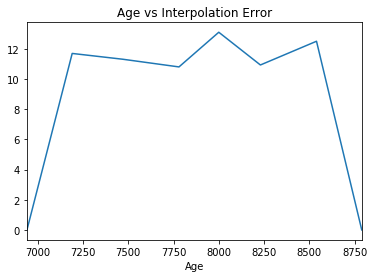

In [10]:
# Display and save plot

data = pd.read_csv(csv_file).set_index('Age')
data_plot = data.plot(title = "Age vs Interpolation Error", legend = None)

data_plot.get_figure().savefig("Results/" + experiment + "/" + experiment + ".png")